In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons

import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import warnings
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda
from tensorflow.keras.initializers import HeNormal

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-qok5aukd
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-qok5aukd
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440342 sha256=7fca6e0103febce8e24143e89031fb10a4299f166a72e20072c9eee785e1ea21
  Stored in directory: /tmp/pip-ephem-wheel-cache-zo_3zojw/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.3 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Suc

2025-10-19 17:53:02.814655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760896383.004655      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760896383.063175      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
working_dir = '/kaggle/working'
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path) 
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")


❌ xóa thành công /kaggle/working/.virtual_documents


In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):   
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []
    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")       
        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            img = img / 255.0
            mask = mask / 255.0

            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            label = mel_label[index]

            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [ ]:
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Train_Data',
    mask_path='/kaggle/input/isic-2750/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Train_GroundTruth_2',
    csv_file="/kaggle/input/2075-csv/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 1925/1925 [05:26<00:00,  5.90it/s]



Đã đọc thành công 1925 ảnh
Shape của images: (1925, 256, 256, 3)
Shape của masks: (1925, 256, 256, 1)
Shape của labels: (1925,)


In [5]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Test_Data',
    mask_path='/kaggle/input/isic-2750/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Test_GroundTruth_2',
    csv_file='/kaggle/input/2075-csv/Test_GroundTruth_3 (1).csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 825/825 [01:59<00:00,  6.89it/s]



Đã đọc thành công 825 ảnh
Shape của images: (825, 256, 256, 3)
Shape của masks: (825, 256, 256, 1)
Shape của labels: (825,)


In [6]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [ ]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
def ConvBlock(inputs, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)

    conv2 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)
    
    return act2

def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1


def decoder(inputs, skip, filters=64):
    Upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out

def get_U_Net(image_size):
    inputs = layers.Input(image_size)

    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)   

    conv_block = ConvBlock(encoder_4, 64*16)    

    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)
    
    model = models.Model(inputs, outputs)
    return model

input_shape = (256, 256, 1)
model = get_U_Net(input_shape)
model.summary()

I0000 00:00:1760896843.447863      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760896843.448452      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [9]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [10]:
pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


In [ ]:
def convert_to_gray_clahe(images):
    grays = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  

    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

        img_clahe = clahe.apply(gray)  
        grays.append(img_clahe)

    return np.array(grays)
train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

In [ ]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

input_shape = (256, 256, 1)
unet = get_U_Net(input_shape)

unet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)
model_checkpoint_dir = 'model'

checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'gray2750.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)

start_time = time.time()
history = unet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])


print("unet output shape:", unet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100


I0000 00:00:1760896870.175568     194 service.cc:148] XLA service 0x7d10c40068e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760896870.176230     194 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760896870.176257     194 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760896871.850367     194 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-19 18:01:22.374405: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_sch

60/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.7786 - jaccard_coefficient: 0.4011 - loss: 0.4390

E0000 00:00:1760897119.556638     193 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760897119.787219     193 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760897125.629206     193 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760897125.945589     193 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760897133.753335     193 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7797 - jaccard_coefficient: 0.4024 - loss: 0.4376
Epoch 1: loss improved from inf to 0.35817, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.7807 - jaccard_coefficient: 0.4036 - loss: 0.4364 - learning_rate: 0.0010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9031 - jaccard_coefficient: 0.5921 - loss: 0.2586
Epoch 2: loss improved from 0.35817 to 0.24861, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9031 - jaccard_coefficient: 0.5924 - loss: 0.2585 - learning_rate: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9166 - jaccard_coefficient: 0.6447 - loss: 0.2177
Epoch 3: loss improved from 0.24861 to 0.21439, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9166 - jaccard_coefficient: 0.6447 - loss: 0.2177 - learning_rate: 0.0010
Epoch 4/100
61/61 ━━

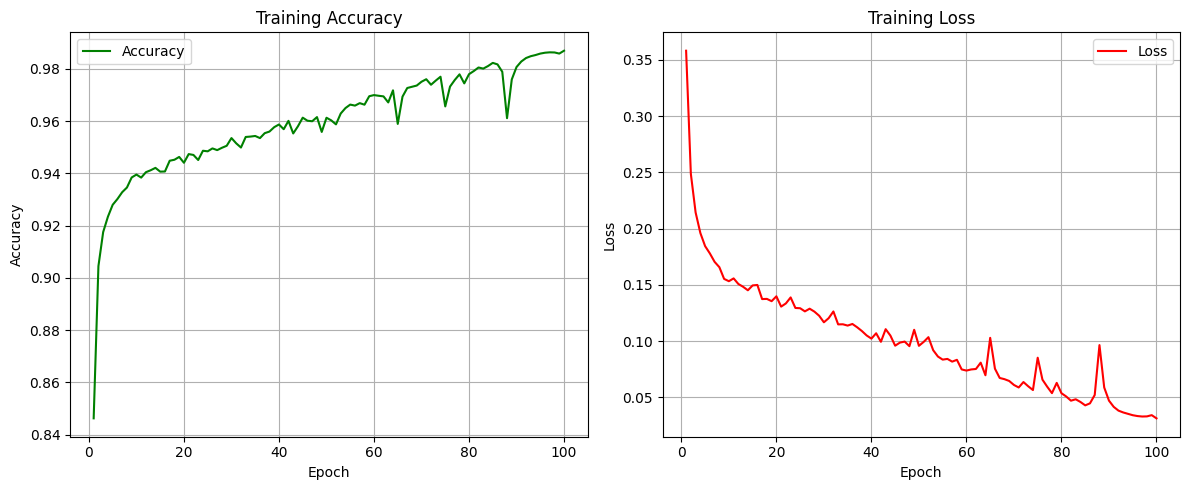

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Gray_2750_acc_loss.png', dpi=300)
plt.show()


In [ ]:
def apply_morphology(mask, kernel_size=3, iterations=1):

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8) 
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32) 

print("🔍 Đánh giá không hậu xử lý...")
results = unet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")
print("\n🔧 Đánh giá sau Morphology...")
predictions1 = unet.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()

    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)


refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)
accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.9513 - jaccard_coefficient: 0.7950 - loss: 0.1164

E0000 00:00:1760908902.517481     195 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760908902.778756     195 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9509 - jaccard_coefficient: 0.7905 - loss: 0.1194 
Không hậu xử lý - Dice Loss: 0.1563, Accuracy: 94.57%, Jaccard: 73.43%

🔧 Đánh giá sau Morphology...
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 774ms/step


100%|██████████| 825/825 [00:00<00:00, 1612.69it/s]


Sau Morphology - Dice Loss: 0.1379, Accuracy: 94.58%, Jaccard: 75.76%


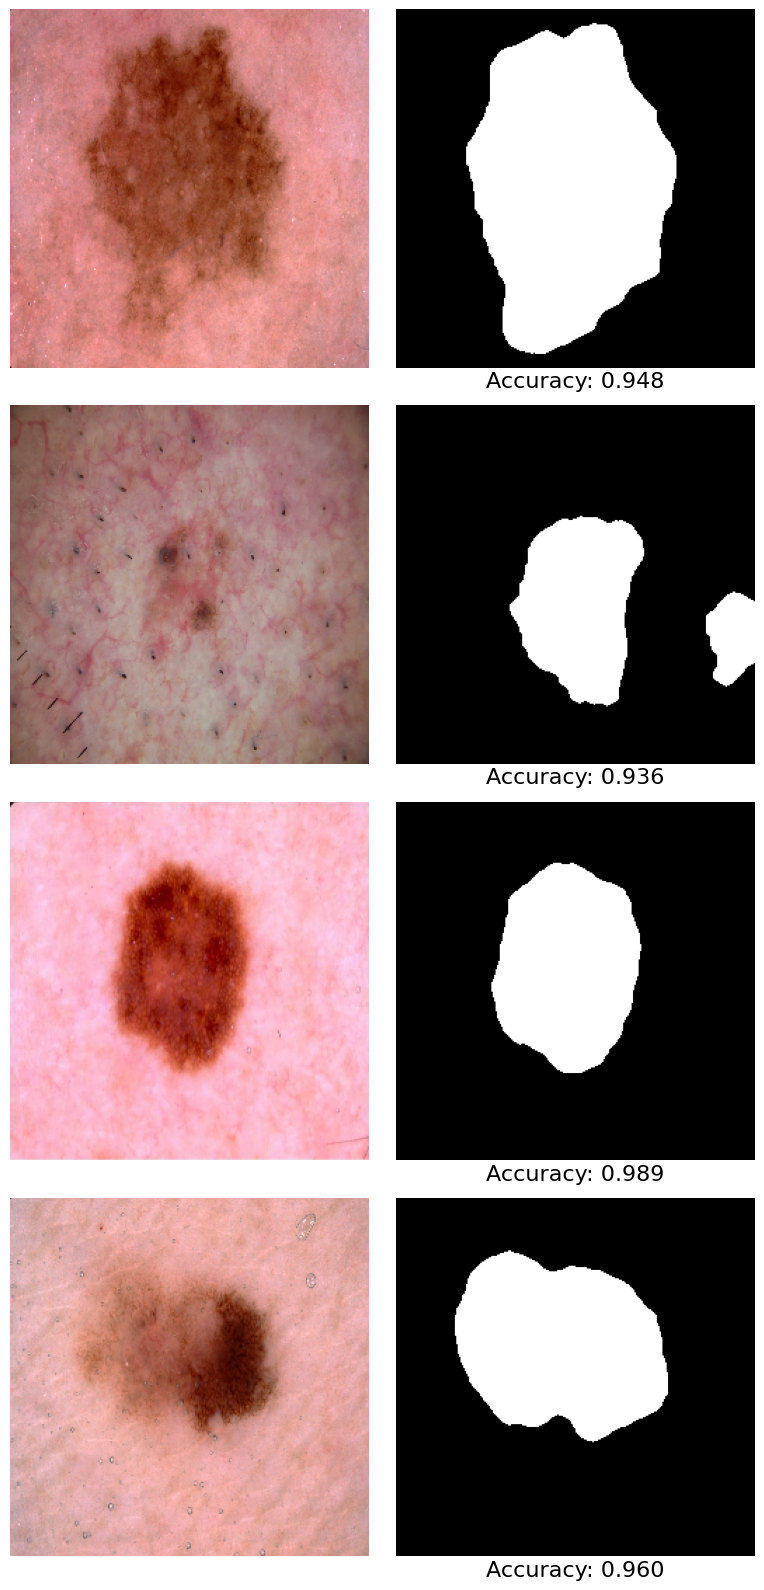

In [ ]:
def show_predictions_with_metrics_grid(refined_predictions1,
                                       images, masks,
                                       indices,
                                       save_path):

    num_images = len(indices)
    plt.figure(figsize=(8, 4 * num_images))  

    for i, idx in enumerate(indices):
        image = images[idx]
        true_mask = masks[idx]
        pred_morph = refined_predictions1[idx]

        if pred_morph.shape != true_mask.shape:
            pred_morph = cv2.resize(pred_morph, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        accuracy = np_accuracy(true_mask, pred_morph)


        ax1 = plt.subplot(num_images, 2, 2*i + 1)
        ax1.imshow(image)
        ax1.axis('off')


        ax2 = plt.subplot(num_images, 2, 2*i + 2)
        ax2.imshow(pred_morph, cmap='gray')   
        ax2.axis('off')
        ax2.text(0.5, -0.01,
                 f"Accuracy: {accuracy:.3f}",
                 fontsize=16, ha='center', va='top', transform=ax2.transAxes)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

show_predictions_with_metrics_grid(
    refined_predictions1=refined_predictions1,
    images=test_images,
    masks=test_masks,
    indices=[722, 191, 54, 700],
    save_path='best_morphology_results_gray_2750.png'
)

In [17]:
unet.save('/kaggle/working/model/2.0-gray_2750_model.h5')
unet.save('/kaggle/working/model/2.0-gray_2750_model.keras')